## Mean Gene expresion of DEG's in Non-naive CD4 T cells 

In [1]:
# load libraries
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(tidyverse)
quiet_library(Seurat)
quiet_library(ggplot2)
quiet_library(Matrix)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library(harmony)
quiet_library(future)
quiet_library(future.apply)
quiet_library(SingleCellExperiment)
quiet_library(SeuratDisk)
quiet_library(ggpubr)
quiet_library(knitr)
quiet_library(plotly)
quiet_library(ggsci)
quiet_library(aplot)
quiet_library(cowplot)
quiet_library(DESeq2)
quiet_library(ggrepel)
options(warn = -1)

In [2]:
# Check number of cores
future::availableCores()
# Set up parallel processing to run when using 'future' functions 
future::plan(strategy = "multicore", workers = future::availableCores()-5)  
options(future.globals.maxSize = 1000 * 1024^3)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")

system 
    64

In [3]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")

cluster_colors_ext <- colorRampPalette(cluster_colors)(75)
options(repr.plot.width = 5, repr.plot.height = 5)

In [4]:
fig_path="/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/"

In [5]:
#' # Function: create_ma_plot
#' # This function generates an MA plot to visualize the mean expression vs. log2 fold change of genes, 
#' # highlighting specified genes and labeling them on the plot.
#'
#' @param data A dataframe containing the necessary columns: mean_expression, log2FoldChange, gene, and color_group.
#' @param genes_to_plot A vector of genes to highlight and label on the plot.
#' @param save_path The directory where the plot should be saved.
#' @param fig_name The name of the file for the saved plot.
#'
#' @return A ggplot2 plot object representing the MA plot.
#' 
#' @details 
#' The function generates an MA plot with different colors for upregulated and downregulated genes. 
#' It highlights and labels specified genes using `geom_point()` and `geom_text_repel()` for text annotations.
#' The plot is saved as a PDF or image file in the specified path.
#' 
#' @example
#' create_ma_plot(
#'   data = gene_expression_data, 
#'   genes_to_plot = c("geneA", "geneB", "geneC"), 
#'   save_path = "path/to/save/plots", 
#'   fig_name = "MA_plot.pdf"
#' )
#'

create_ma_plot <- function(data, genes_to_plot, save_path, fig_name) {
  # Generate the plot
  plot <- ggplot(data, aes(x = mean_expression, y = log2FoldChange, color = color_group)) +
    geom_point(size = 3, alpha = 0.5,stroke=0) +  # Yellow fill with black outline for non-highlighted genes
    geom_point(data = subset(data, gene %in% genes_to_plot), 
               aes(x = mean_expression, y = log2FoldChange), 
              fill = "#fee090", color = "black", size = 3, shape = 21, stroke = .5) +  # Black outline for highlighted genes
    geom_text_repel(
      data = subset(data, gene %in% genes_to_plot), 
      aes(label = gene),
      nudge_x = 4.5,  # Use a constant value to move the gene names to the right or left
      segment.size = 0.2,
      segment.color = "#595959",
      direction = "y",
      hjust = -0.4,
      vjust = -0.7,
      size = 5,
      color = "black",
      max.overlaps = 35,
      min.segment.length = 0
    ) +
    theme_light() +
    labs(x = "Mean Expression of Genes", y = "Log2 Fold Change") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    scale_color_manual(values = c("sig_up" = "red", "sig_down" = "blue"),
                       labels = c("Downregulated", "Upregulated")) +
    ylim(-3, 3) +  # Set y-axis limit to -2 to 2
    theme(legend.position = "top",
          legend.title = element_blank())

  # Save the plot
  ggsave(filename = file.path(save_path, fig_name), plot = plot, width = 5, height = 5)
  
  # Return the plot object in case it needs to be displayed or further modified
  return(plot)
}


In [6]:
degs_C3=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/output_files/CD4T_mem_certpro_DEGs_wilcoxon_res_0.4_CLUSTER_3_Filtered_vs_Rest_py.csv")
degs_C3%>%head()
degs_C3%>%dim

,X,names,scores,logfoldchanges,pvals,pvals_adj,direction
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0,LIMS1,173.4471,2.0587560,0,0,up
2,1,FYB1,125.4221,0.9869149,0,0,up
3,2,KLRB1,119.8633,1.7975423,0,0,up
4,3,MAF,117.4443,1.7790763,0,0,up
5,33537,RPS3,-117.3739,-0.3322848,0,0,down
6,4,NEAT1,116.6669,1.2802397,0,0,up


[1] 33538     7

In [7]:
# reading the mean gene expression 
gene_exp_df=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/output_files/ALTRA_CD4_Tmem_MEAN_GENE_Exp_not_scaled.csv")
gene_exp_df%>%dim
gene_exp_df%>%head(3)

[1] 33538     3

,X,gene,mean_expression
,<int>,<chr>,<dbl>
1,0,MIR1302-2HG,3.428282e-06
2,1,FAM138A,0.000000e+00
3,2,OR4F5,0.000000e+00


In [8]:
degs_C3 <- degs_C3 %>%
  rename(
    log2FoldChange = logfoldchanges,
    pvalue = pvals,
    padj = pvals_adj,
    gene=names
  )
degs_C3%>%head(3)

,X,gene,scores,log2FoldChange,pvalue,padj,direction
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0,LIMS1,173.4471,2.0587560,0,0,up
2,1,FYB1,125.4221,0.9869149,0,0,up
3,2,KLRB1,119.8633,1.7975423,0,0,up


In [9]:
# joining the mean experssion data with the DEG results 
m_df=left_join(degs_C3,gene_exp_df,by="gene")
m_df%>%head(3)
m_df%>%dim

,X.x,gene,scores,log2FoldChange,pvalue,padj,direction,X.y,mean_expression
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
1,0,LIMS1,173.4471,2.0587560,0,0,up,4293,0.6163804
2,1,FYB1,125.4221,0.9869149,0,0,up,8821,1.4777321
3,2,KLRB1,119.8633,1.7975423,0,0,up,20318,0.7435725


[1] 33538     9

In [10]:
## removing the unwanted columns
m_df <- m_df %>% select(-X.x, -X.y)
m_df%>%head(3)
m_df%>%dim

,gene,scores,log2FoldChange,pvalue,padj,direction,mean_expression
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,LIMS1,173.4471,2.0587560,0,0,up,0.6163804
2,FYB1,125.4221,0.9869149,0,0,up,1.4777321
3,KLRB1,119.8633,1.7975423,0,0,up,0.7435725


[1] 33538     7

In [11]:
genes_to_plot =c('CD3D','RORA','MAF','TCF7','IL6ST','CD28','CD3G','STAT5B','CASP8','TRAF5',
                 'ICOS','CD247','NFAT5','STAT2','IKBKB','STIM1','FOSB','NKFB1','STAT6','PDCD1',
                'CXCR5','KLRB1','CCR6')

In [12]:
# Create a new column 'sig' based on the 'padj' values
m_df <- m_df %>%
  mutate(sig = ifelse(padj > 0.01, "non-significant", "significant"))
m_df%>%head(3)

,gene,scores,log2FoldChange,pvalue,padj,direction,mean_expression,sig
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,LIMS1,173.4471,2.0587560,0,0,up,0.6163804,significant
2,FYB1,125.4221,0.9869149,0,0,up,1.4777321,significant
3,KLRB1,119.8633,1.7975423,0,0,up,0.7435725,significant


In [14]:
#creating the new column to color the plot based on significance 
m_df <- m_df %>%
  mutate(color_group = case_when(
    sig == "significant" & direction == "up" ~ "sig_up",
    sig == "significant" & direction == "down" ~ "sig_down",
    TRUE ~ "non_significant"
  ))
m_df%>%head()

,gene,scores,log2FoldChange,pvalue,padj,direction,mean_expression,sig,color_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,LIMS1,173.4471,2.0587560,0,0,up,0.6163804,significant,sig_up
2,FYB1,125.4221,0.9869149,0,0,up,1.4777321,significant,sig_up
3,KLRB1,119.8633,1.7975423,0,0,up,0.7435725,significant,sig_up
4,MAF,117.4443,1.7790763,0,0,up,0.3827063,significant,sig_up
5,RPS3,-117.3739,-0.3322848,0,0,down,4.1264950,significant,sig_down
6,NEAT1,116.6669,1.2802397,0,0,up,1.1937958,significant,sig_up


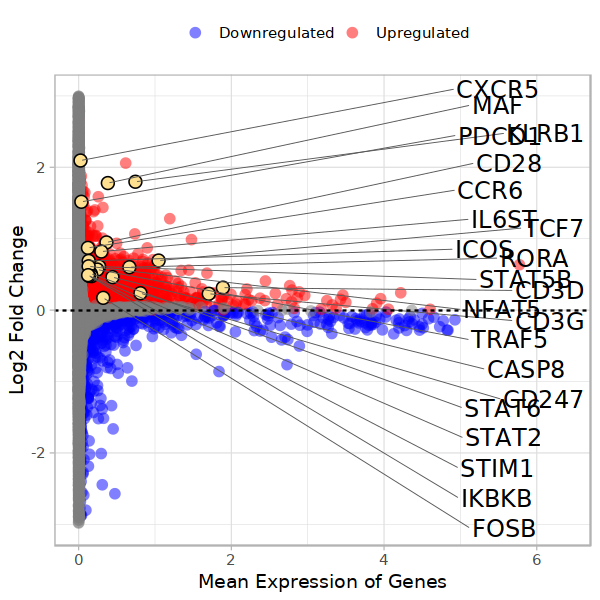

In [15]:
create_ma_plot(data = m_df, genes_to_plot = genes_to_plot, save_path = fig_path, fig_name = "Fig_S6_C.pdf")

In [16]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/jupyter/libs/r_scrna/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.5               DESeq2_1.40.2              
 [3] cowplot_1.1.3               aplot_0.2.3                
 [5] ggsci_3.2.0                 plotly_4.10.4              
 [7] knitr_1.47                  ggpubr_0.6.0               
 [9] SeuratDisk_0.0.0.9021       Single